In [ ]:

%load_ext autoreload
%autoreload 2
DATA_SEED = 613
MODEL_SEED = 26
LANGEVIN_SEED = 480
import juliacall
import os
import torch
import numpy as np
from dataclasses import dataclass, field
import sys
import scipy.stats as stats
from juliacall import Main as jl
jl.include('/home/akiva/FCNX-Ensembling/julia_lib/FCS.jl')
sys.path.insert(0, '/home/akiva/FCNX-Ensembling')
torch.manual_seed(DATA_SEED)
torch.set_default_dtype(torch.float64)
DEVICE = torch.device('cuda:1')
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
from FCN3Network import FCN3NetworkEnsembleErf
from Experiment import Experiment



experimentMF = Experiment(
    eps=0.03,
    file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
    N=400,
    d=40,
    chi=50,
    P=250,
    ens=3,
    device = torch.device('cuda:1')
)

experimentNNGP = Experiment(
    eps=0.03,
    file="/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_2000000_lrA_7.69e-11_time_20251029_120218",
    N=250,
    d=25,
    chi=1.0,
    P=130,
    ens=7
)


# experimentMFSmallD.load()
experimentMF.load()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401/model.pth


In [31]:

i0 = np.array([0.01, 1.0e-5, 0.04, 1.e-5])
χ = experimentMF.chi
d = experimentMF.d
n = experimentMF.N
ϵ = experimentMF.eps
π = np.pi
δ = float(1.0)
P = experimentMF.P
lr = float(1.0e-6)
Tf = 6000000

lT = jl.FCS.nlsolve_solver(
    juliacall.convert( jl.Vector[jl.Float64], i0),
    chi=χ, d=d, kappa=1.0, delta=δ,
    epsilon=ϵ, n=n, b=4 / (3 * π),
    P=P, lr=lr, max_iter=Tf, verbose=False, anneal=True
)
δ = 0.0
lP = jl.FCS.nlsolve_solver(
    juliacall.convert(jl.Vector[jl.Float64], i0),
    chi=χ, d=d, kappa=1.0, delta=δ,
    epsilon=ϵ, n=n, b=4 / (3 * π),
    P=P, lr=lr, max_iter=Tf, verbose=False, anneal=True
)
print("Target Eigenvalues: ")
print(f"lH1: {lT[2]: 0.6f} lH3: {lT[3]: 0.6f} lJ1: {lT[0]: 0.6f} lJ3: {lT[1]:0.6f}")
print("Perpendicular Eigenvalues: ")
print(f"lH1: {lP[2]: 0.6f} lH3: {lP[3]: 0.6f} lJ1: {lP[0]: 0.6f} lJ3: {lP[1]: 0.6f}")

Target Eigenvalues: 
lH1:  0.133272 lH3:  0.000040 lJ1:  0.010114 lJ3: 0.000038
Perpendicular Eigenvalues: 
lH1:  0.010610 lH3:  0.000044 lJ1:  0.010610 lJ3:  0.000044


In [69]:
t = experimentMF.model.W0[:,:,0].detach().cpu()
k1 = stats.kstat(t, n=1)  # 1st cumulant estimator (mean): 2.5
k2 = stats.kstat(t, n=2)  # 2nd (unbiased variance): ≈1.6667
k3 = stats.kstat(t, n=3)  # 3rd: 0.0
k4 = stats.kstat(t, n=4)  # 4th: ≈-3.3333

print("Cumulants")
print(f"  k1: {k1}")
print(f"  k2: {k2}")
print(f"  k3: {k3}")
print(f"  k4: {k4}")

Cumulants
  k1: 0.0041674796606940515
  k2: 0.05929161929687906
  k3: 0.002309841059040377
  k4: -0.0007369915415788506


According to these numbers, yes we are not gaussian

In [70]:
t = experimentNNGP.model.W0[:, :, 1:].detach().cpu()
k1 = stats.kstat(t, n=1)  # 1st cumulant estimator (mean): 2.5
k2 = stats.kstat(t, n=2)  # 2nd (unbiased variance): ≈1.6667
k3 = stats.kstat(t, n=3)  # 3rd: 0.0
k4 = stats.kstat(t, n=4)  # 4th: ≈-3.3333

print("Cumulants")
print(f"  k1: {k1}")
print(f"  k2: {k2}")
print(f"  k3: {k3}")
print(f"  k4: {k4}")

Cumulants
  k1: -0.0012715553635558965
  k2: 0.039833689180480567
  k3: 0.0001655197635643514
  k4: 3.981830569189093e-05


<>:19: SyntaxWarning: invalid escape sequence '\s'
<>:19: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_64650/1952176194.py:19: SyntaxWarning: invalid escape sequence '\s'
  ax.plot(x, norm_curve, 'r--', label='Normal Distribution: mu={:.3f}, $\sigma^2$={:.3f}'.format(mu, sigma**2))


---------------(((( MF Exp ))))------------


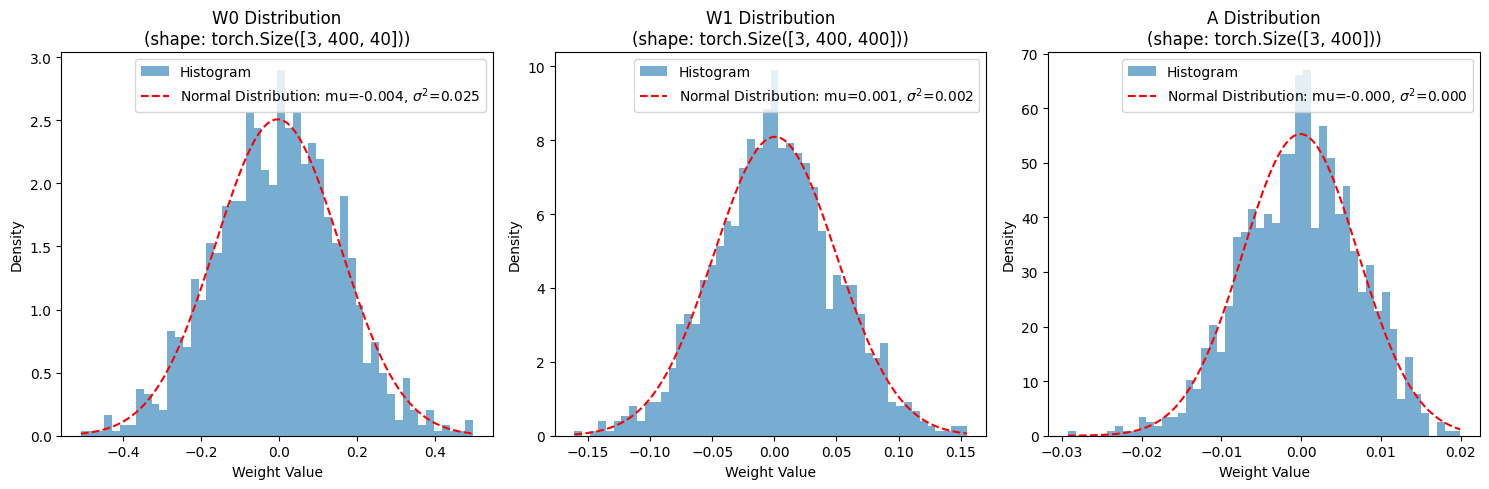


Summary Statistics:

W0 Targ:
Mean: -0.004191
Std: 0.159065
Skewness: -0.014823
Kurtosis: 0.043569

W1 Perp:
Mean: 0.000515
Std: 0.049292
Skewness: 0.019949
Kurtosis: 0.074723

A:
Mean: -0.000096
Std: 0.007218
Skewness: -0.227775
Kurtosis: 0.019417

Shapiro-Wilk Test (p-value):
W0: 0.725294
W1: 0.731172
A:  0.001987
---------------(((( SSC Exp ))))------------


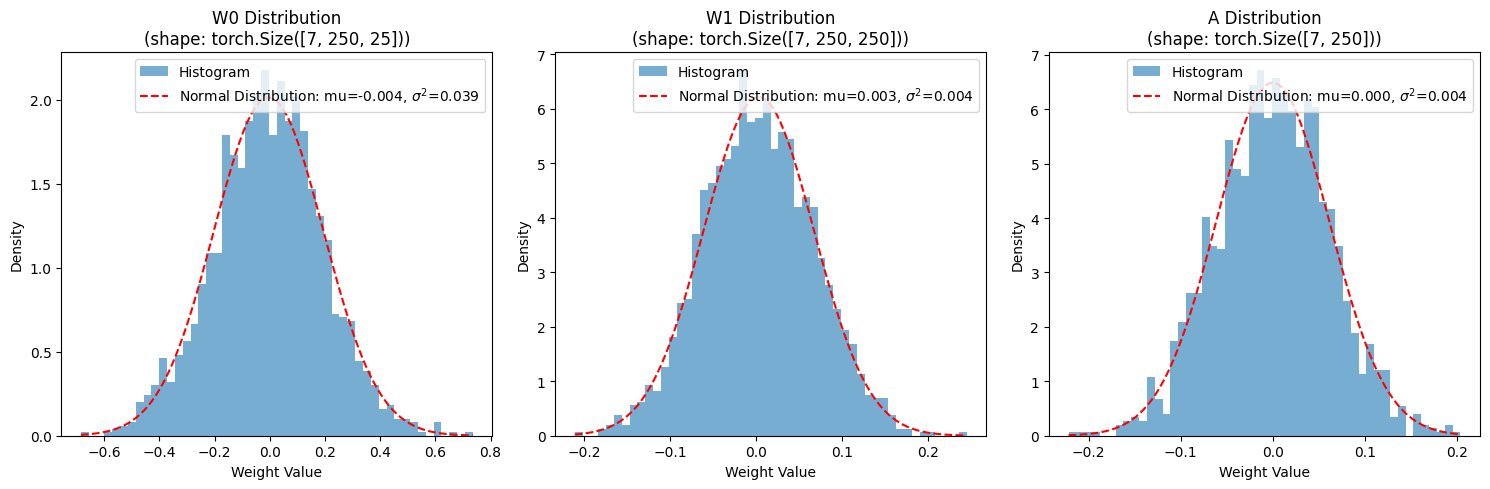


Summary Statistics:

W0 Targ:
Mean: -0.004105
Std: 0.198124
Skewness: -0.001242
Kurtosis: 0.159701

W1 Perp:
Mean: 0.003364
Std: 0.064165
Skewness: 0.032531
Kurtosis: -0.114239

A:
Mean: 0.000018
Std: 0.061507
Skewness: -0.018655
Kurtosis: 0.061277

Shapiro-Wilk Test (p-value):
W0: 0.315797
W1: 0.839424
A:  0.624829


In [77]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def gaussianity_test(experiment):
    model = experiment.model
    # Set up the figure with three subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

    # Helper function to plot histogram and normal curve
    def plot_distribution(ax, data, title):
        # Plot histogram
        counts, bins, _ = ax.hist(data, bins=50, density=True, alpha=0.6, label='Histogram')
        
        # Fit and plot normal distribution
        mu, sigma = np.mean(data), np.std(data)
        x = np.linspace(min(bins), max(bins), 100)
        norm_curve = stats.norm.pdf(x, mu, sigma)
        ax.plot(x, norm_curve, 'r--', label='Normal Distribution: mu={:.3f}, $\sigma^2$={:.3f}'.format(mu, sigma**2))
        
        ax.set_title(title)
        ax.set_xlabel('Weight Value')
        ax.set_ylabel('Density')
        ax.legend()


    # Plot W0 distribution
    w0_flat = model.W0[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax1, w0_flat, f'W0 Distribution\n(shape: {model.W0.shape})')

    # Plot W1 distribution
    w1_flat = model.W1[:, :, 0].detach().cpu().numpy().flatten()
    plot_distribution(
        ax2, w1_flat, f'W1 Distribution\n(shape: {model.W1.shape})')

    # Plot A distribution
    a_flat = model.A.detach().cpu().numpy().flatten()
    plot_distribution(ax3, a_flat, f'A Distribution\n(shape: {model.A.shape})')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nSummary Statistics:")
    print("\nW0 Targ:")
    print(f"Mean: {np.mean(w0_flat):.6f}")
    print(f"Std: {np.std(w0_flat):.6f}")
    print(f"Skewness: {stats.skew(w0_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w0_flat):.6f}")

    print("\nW1 Perp:")
    print(f"Mean: {np.mean(w1_flat):.6f}")
    print(f"Std: {np.std(w1_flat):.6f}")
    print(f"Skewness: {stats.skew(w1_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(w1_flat):.6f}")

    print("\nA:")
    print(f"Mean: {np.mean(a_flat):.6f}")
    print(f"Std: {np.std(a_flat):.6f}")
    print(f"Skewness: {stats.skew(a_flat):.6f}")
    print(f"Kurtosis: {stats.kurtosis(a_flat):.6f}")

    # Add Shapiro-Wilk test for normality
    print("\nShapiro-Wilk Test (p-value):")
    print(f"W0: {stats.shapiro(w0_flat)[1]:.6f}")
    print(f"W1: {stats.shapiro(w1_flat)[1]:.6f}")
    print(f"A:  {stats.shapiro(a_flat)[1]:.6f}")

print("---------------(((( MF Exp ))))------------")
gaussianity_test(experimentMF)
print("---------------(((( SSC Exp ))))------------")
gaussianity_test(experimentNNGP)

In [63]:
p = experimentMF.eig_predictions()
delta = 1.0
π = np.pi
b = 4 / (3 * np.pi)
lJ1, lJ3, lH1, lH3 = p.lJ1T, p.lJ3T, p.lH1T, p.lH3T
d = experimentMF.d
lV1 = (lH1 / lJ1**2 - 1 / lJ1)
lV3 = (lH3 / lJ3**2 - 1 / lJ3)
lWT = 1 / (d + delta * b * (lV1) / n)
lWP = 1 / d

TrSigma = lWT + lWP * (d - 1)
EChh = lH1 + lH3 + \
       (16 / (π * (1 + 2 * TrSigma)**3) * (15 * lWP**3)) * (d - 1) + \
       (4 / (π * (1 + 2 * TrSigma)) * lWP) * (d - 1) 
gammaYh2 = (4 / π) / (1 + 2 * EChh)
lK1 = gammaYh2 * lH1
lK3 = gammaYh2 * lH3

In [72]:
p

Eigenvalues(lJ1T=0.030559305571941246, lJ3T=0.0010562371939381566, lH1T=0.08898911311641355, lH3T=0.001059926594569286, lJ1P=0.010610329539460598, lJ3P=4.42097064144154e-05, lH1P=0.010610329539460598, lH3P=4.42097064144154e-05, lK1T=0.056337435591480724, lK3T=0.0006710208042542096, lK1P=0.0072931116275181855, lK3P=3.038796511465652e-05)

In [ ]:
def plot_distribution(ax, data, title):
    # Plot histogram
    counts, bins, _ = ax.hist(data, bins=40, density=True, alpha=0.6, label='Histogram')
    
    # Fit and plot normal distribution
    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(min(bins), max(bins), 40)
    norm_curve = stats.norm.pdf(x, mu, sigma)
    ax.plot(x, norm_curve, 'r--', label='Normal Distribution')
    
    ax.set_title(title)
    ax.set_xlabel('Weight Value')
    ax.set_ylabel('Density')
    ax.legend()


In [ ]:
np.mean(model.W0.detach().cpu().numpy()[:, :, 0].flatten())

0.003955217928619953

In [ ]:
np.mean(model.W0.detach().cpu().numpy()[:, :, 1:].flatten())

0.0005105941633795118

NameError: name 'plot_distribution' is not defined

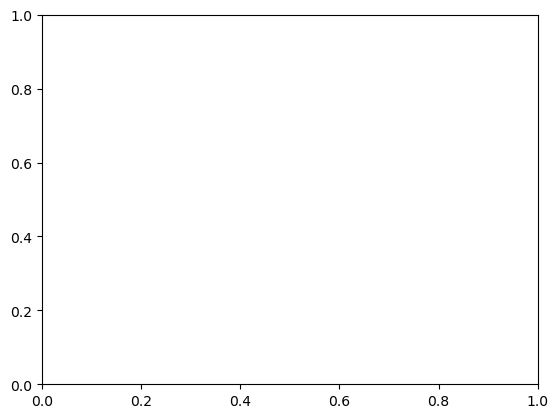

In [ ]:

fig, ax = plt.subplots()
plot_distribution(ax, model.W0.detach().cpu().numpy()[:, :,0].flatten(), 'W0 Target Dist')

In [ ]:
def covariance_over_k_averaged(W: torch.Tensor) -> torch.Tensor:
    """
    Parameters
    ----------
    W : torch.Tensor
        Tensor of shape (I, J, K).  `i` = 0..I-1, `j` = 0..J-1, `k` = 0..K-1.

    Returns
    -------
    torch.Tensor
        A (K, K) covariance matrix obtained by:
          1. For every (i,j) compute cov(W[i,j,:])
          2. Average those (I*J) covariance matrices.
    """
    I, J, K = W.shape

    # 1. Reshape so that each (i,j) is a separate "sample"
    #    -> shape (I*J, K)
    X = W.reshape(I * J, K)                # (N, K)  with N = I*J

    # 2. Center the data (subtract column means)
    X_centered = X - X.mean(dim=1, keepdim=True)   # (N, K)

    # 3. Compute the (biased) covariance for each sample separately
    #    cov_per_sample = (1/K) * X_centered.T @ X_centered   would be the *global* cov
    #    Instead we need the per-sample cov and then average them:
    #    cov_ij = (1/(K-1)) * X_centered[n:n+1].T @ X_centered[n:n+1]
    #    (the 1/(K-1) is the unbiased estimator for a single vector)

    # Vectorized per-sample outer product:
    #    (N, K, 1) @ (N, 1, K)  ->  (N, K, K)
    outer = X_centered.unsqueeze(-1) * X_centered.unsqueeze(-2)   # (N, K, K)

    # Unbiased covariance for a single vector of length K:
    cov_per_ij = outer / (K - 1)                                 # (N, K, K)

    # 4. Average over all (i,j) pairs
    cov_avg = cov_per_ij.mean(dim=0)                            # (K, K)

    return cov_avg

# cov_avg = covariance_over_k_averaged(model.W1).detach().cpu().numpy()


In [ ]:
model = experimentMF.model
import matplotlib.pyplot as plt

<BarContainer object of 40 artists>

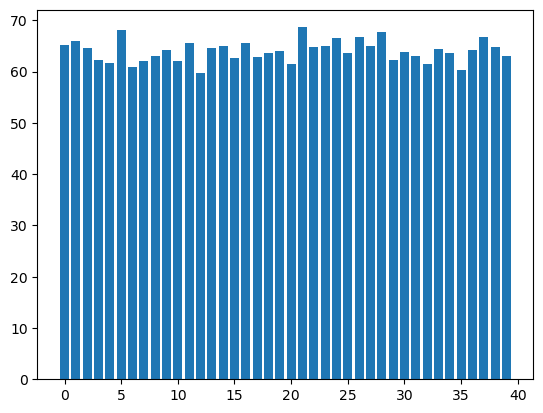

In [ ]:
Σ_W0 = torch.einsum('qim, qim-> m', model.W0, model.W0).detach().cpu().numpy()
plt.bar(range(Σ_W0.shape[0]), Σ_W0)

In [ ]:
ens

NameError: name 'ens' is not defined

In [78]:
#model = experimentMF.model.to('cuda:0')

experimentMF.device = 'cpu'
experimentMF.model.to(torch.device('cpu'))

X_inf, Yinf = experimentMF.large_dataset(p_large=2000,device='cpu')
Y1_inf, Y3_inf = Yinf
Y3_inf = Y3_inf / 6**0.5
kappa = 1.0
Y = Y1_inf
X = X_inf


def λKs(expr, X, Y, l='h1', std = False, a = 1.0, mux = None):
    """
    a: The orthogonality scale <g,Kg> = a*<g,g>
    """
    with torch.no_grad():
        g = {
            'k': lambda x: torch.transpose(expr.model(x), 1,2),
            'h1': expr.model.h1_preactivation
        }
        model = expr.model

        N = expr.N
        P = X.shape[0]
        # Kernel is averaged over ensemble and neuron indices
        f_inf = g[l](X)

        #f_inf: P * ens * N
        # Implicitly summing over N to obtain P * P * ens
        hh_inf_i = torch.einsum('uim,vim->uvi', f_inf, f_inf)/ (N * P)
        # Summing over ensembles
        hh_inf = torch.sum(hh_inf_i, axis=2) / (expr.ens) # Sample covariance

        norm = torch.einsum('ij,ij->j', Y.squeeze(), Y.squeeze()) / P

        # Ens * d
        Ls_i = torch.einsum('uj,uvi,vj->ij', Y.squeeze(), 
                            hh_inf_i, Y.squeeze()) / P
        lsT_i = Ls_i/norm


        std_ls = torch.std(lsT_i, axis=0).detach().cpu().numpy()


        # Large matrix projection
        Ls = torch.einsum('uj,uv,vj->j', Y.squeeze(), 
                        hh_inf, Y.squeeze()) / P


        lsT = Ls/norm
        lsT = lsT.detach().cpu().numpy()
        if not std: 
            return lsT
        else:
            return lsT, std_ls

def l_ratio(expr, ls):
    return ls / (ls + kappa/expr.P)

def eigs(expr, X, Y1, Y3):
    mux = None #torch.exp(-torch.linalg.norm(X, axis=1)/2) * 1/(2*torch.pi)**X.shape[1]
    λH1,σλH1  = λKs(expr, X, Y1, l='h1', std=True)
    λH3, σλH3 = λKs(expr, X, Y3, l='h1', std=True)
    return {
        'λH1': λH1,
        'σλH1': σλH1, 
        'λH3': λH3,
        'σλH3': σλH3
    }

def learnabilities(exp, X_inf, Y1_inf, Y3_inf):
    mux = None #torch.exp(-torch.linalg.norm(X, axis=1)/2)

    l1 = l_ratio(exp, exp.model.K_eig(X_inf, Y1_inf))
    l3 = l_ratio(exp, exp.model.K_eig(X_inf, Y3_inf))
    return {
        "μ_He1": l1,
        "μ_He3": l3
    }
eigdict = eigs(experimentMF, X_inf, Y1_inf, Y3_inf)
eigdict

{'λH1': array([0.01436881, 0.01049872, 0.00981152, 0.01015469, 0.0102812 ,
        0.01082658, 0.01020761, 0.01088233, 0.01083312, 0.01041827,
        0.0111496 , 0.01043792, 0.0098751 , 0.01090674, 0.01107039,
        0.01043303, 0.01113751, 0.01079785, 0.01063088, 0.01084033,
        0.01083819, 0.01104726, 0.01058301, 0.01086573, 0.01139015,
        0.00975815, 0.01056384, 0.01106176, 0.01187282, 0.00952194,
        0.01066617, 0.01054202, 0.0112175 , 0.01024619, 0.01093081,
        0.00970884, 0.01003364, 0.01143784, 0.01106054, 0.01079427]),
 'σλH1': array([0.00176139, 0.00123277, 0.00123048, 0.00117385, 0.00119461,
        0.00123295, 0.00102599, 0.00141937, 0.00149623, 0.00070238,
        0.00134645, 0.0011208 , 0.00102511, 0.00153444, 0.00154079,
        0.00116292, 0.00086971, 0.00075467, 0.00128518, 0.00133664,
        0.00145619, 0.00091206, 0.00133768, 0.00129084, 0.00125744,
        0.00109964, 0.00093389, 0.00162041, 0.00141684, 0.0010037 ,
        0.00096286, 0.00144726,

In [105]:
f = torch.transpose(experimentMF.model(X_inf), 1, 2)
f.shape

torch.Size([1000, 10, 1])

In [106]:
experimentMF.model.h1_activation(X).shape

torch.Size([1000, 10, 256])

In [129]:
lKs = experimentMF.model.K_eig(X_inf, Y3_inf, a = 1 / 6.0)
lKs

tensor([1.4621e-03, 5.2382e-05, 3.4153e-05, 5.7330e-04, 2.4940e-04, 2.5725e-04,
        1.8163e-04, 5.8239e-05, 4.2624e-05, 2.7508e-05, 4.3913e-05, 6.3791e-05,
        1.4062e-04, 9.3617e-05, 1.2321e-03, 7.6663e-05, 6.1931e-05, 3.6289e-04,
        5.1844e-04, 6.5470e-04, 7.3234e-05, 1.1206e-04, 5.4694e-05, 1.3480e-04,
        7.6148e-05, 9.6579e-05, 3.4992e-04, 5.2629e-05, 1.0258e-04, 9.9596e-05,
        6.2522e-05, 1.0231e-03, 5.0033e-05, 4.8359e-04, 1.2924e-03, 2.3111e-05,
        3.9491e-04, 6.1495e-04, 1.0150e-04, 1.0407e-04],
       grad_fn=<DivBackward0>)

In [108]:
λKs(experimentMF, X_inf, Y3_inf, l='k', a=6.0)

array([3.85819619e-10, 9.42126610e-10, 4.50598742e-10, 2.45312718e-10,
       6.27441960e-10, 8.29958012e-10, 8.47808502e-10, 6.57840765e-10,
       1.52355346e-09, 4.28899638e-10, 9.44630718e-10, 3.85629636e-10,
       5.95405777e-10, 9.37643311e-10, 4.39938757e-10, 8.39356593e-10,
       2.85237433e-10, 6.45955802e-10, 3.19956469e-10, 7.75921974e-10,
       9.59098225e-10, 3.00213244e-10, 4.97074728e-10, 2.05918561e-09,
       7.33494612e-10, 4.13574092e-10, 7.75708107e-10, 1.41778986e-09,
       9.83436774e-10, 5.52912208e-10, 2.82688837e-10, 9.91221833e-10,
       1.54352379e-09, 1.28670487e-09, 4.22993324e-10, 6.33000548e-10,
       4.15008575e-09, 6.03511085e-10, 3.05622924e-10, 4.50498232e-10])

In [113]:
learnabilities(experimentMF, X_inf, Y1_inf, Y3_inf)

{'μ_He1': tensor([0.0608, 0.1144, 0.0950, 0.2072, 0.1660, 0.1325, 0.1198, 0.1417, 0.1029,
         0.1860, 0.1059, 0.1118, 0.1336, 0.2094, 0.1449, 0.2093, 0.0968, 0.0692,
         0.1421, 0.0890, 0.0740, 0.1393, 0.2250, 0.1889, 0.1419, 0.1327, 0.1832,
         0.1006, 0.2008, 0.0737, 0.1137, 0.1613, 0.1306, 0.1116, 0.1761, 0.1922,
         0.1805, 0.1252, 0.0903, 0.2258], grad_fn=<DivBackward0>),
 'μ_He3': tensor([0.0006, 0.0015, 0.0007, 0.0004, 0.0010, 0.0013, 0.0014, 0.0011, 0.0024,
         0.0007, 0.0015, 0.0006, 0.0010, 0.0015, 0.0007, 0.0013, 0.0005, 0.0010,
         0.0005, 0.0012, 0.0015, 0.0005, 0.0008, 0.0033, 0.0012, 0.0007, 0.0012,
         0.0023, 0.0016, 0.0009, 0.0005, 0.0016, 0.0025, 0.0021, 0.0007, 0.0010,
         0.0066, 0.0010, 0.0005, 0.0007], grad_fn=<DivBackward0>)}

What I expect: 

```
-------
Semi MF Scaling Target Eigenvalues χ=25
lH1: 0.026213803831268447, lH3: 0.0004390226602199763 
lJ1: 0.01571639334495683, lJ3: 0.00033940306369577007 
Learnabilities
mu1 = 0.34788529309740573
mu3 = 0.008855355587272204
lbs = 0.0004095342496844976
----------
Perpendicular Eigenvalues
lH1: 0.016976534383041655, lH3: 0.0001810915177192627 
lJ1: 0.016976531663479486, lJ3: 0.0001810882479963123 
Learnabilities
mu1 = 0.2587265819314266
mu3 = 0.00370934945933521
```

The theory predicted stronger feature learning in the He3 eigenfunction than what I actually observed in my experiment

In [102]:
experimentMF.predictions = experimentMF.eig_predictions()

In [99]:
experimentMF.load()

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053/model.pth


lH1: [0.00750076 0.00727846 0.00656414 0.00703853 0.00755272 0.00729353
 0.00631738 0.00742493 0.00802483 0.00772143 0.00738169 0.00696247
 0.00735709 0.00748255 0.00741744 0.00743358 0.00671355 0.00681149
 0.00758162 0.00756398 0.00736935 0.00733907 0.00727004 0.00654044
 0.00716497 0.00737308 0.00703156 0.00708174 0.00711927 0.00642066
 0.00659541 0.00691233 0.00821211 0.00797765 0.00803297 0.00717172
 0.0065648  0.00791583 0.00654496 0.00749453] ± [0.00068786 0.00102878 0.0009465  0.00087042 0.00113735 0.00066068
 0.00059093 0.00082874 0.00108505 0.00107189 0.00105284 0.00065617
 0.00063083 0.00096685 0.00067312 0.00085377 0.00085952 0.00076532
 0.00072606 0.00062548 0.00109152 0.00071637 0.00103535 0.00063373
 0.00082416 0.00090003 0.00071726 0.00069252 0.00088796 0.00081489
 0.00103491 0.00087188 0.00077233 0.00092891 0.00108261 0.0010654
 0.00064977 0.0006885  0.00078798 0.00115256] 
λH1_min: [0.0068129  0.00624968 0.00561764 0.0061681  0.00641538 0.00663285
 0.00572646 0.0065961

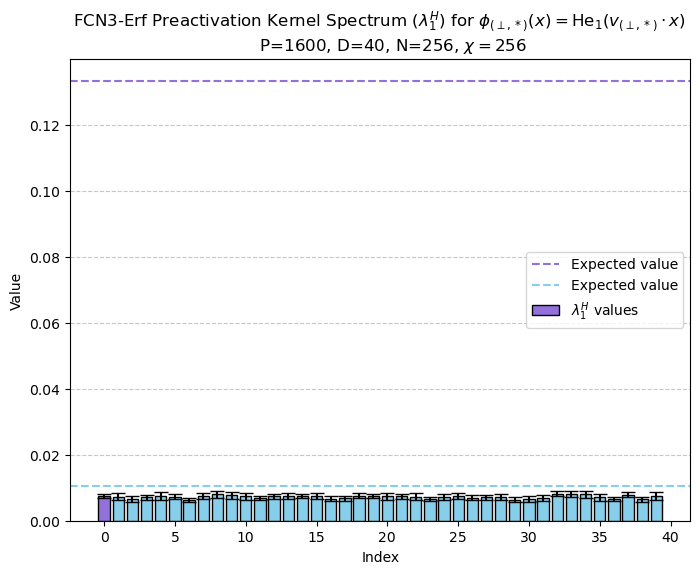

/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053/


In [114]:
predictions = experimentMF.predictions
import numpy as np
import matplotlib.pyplot as plt
k = 'λH1'
print(
    f"lH1: {eigdict[k]} ± {eigdict[f'σ{k}']} ")

lH1_min = eigdict[k] - eigdict[f'σ{k}']
lH1_max = eigdict[k] + eigdict[f'σ{k}']
print(
    f"{k}_min: {lH1_min} ")
lH1expected = predictions.lH1P

print(f"{k}_expected: {lH1expected}")
print(
    f"{k}_max: {lH1_max} ")


# Calculate error bars: asymmetric from min to max relative to heights
yerr_min = eigdict['λH1'] - lH1_min  # Lower error
yerr_max = lH1_max - eigdict['λH1']  # Upper error
yerr = np.array([yerr_min, yerr_max])  # Shape (2, n) for asymmetric errors

# X positions for bars (assuming indexed by array position)
x = np.arange(len(eigdict['λH1']))
target1 = predictions.lH1T

# Create the bar plot
plt.figure(figsize=(8, 6))
colors = ['mediumpurple'] + ['skyblue'] * (len(eigdict['λH1']) - 1)

plt.bar(x, eigdict['λH1'], yerr=yerr, capsize=5,
        color=colors, edgecolor='black', label='$\lambda^H_1$ values')


plt.axhline(y=target1, color='mediumpurple',
            linestyle='--', label='Expected value')

# Add the red dashed line (horizontal across all bars if lH3expected is scalar; or point-wise if array)
if np.isscalar(lH1expected):
    plt.axhline(y=lH1expected, color='skyblue',
                linestyle='--', label='Expected value')
else:
    plt.plot(x, lH1expected, color='skyblue', linestyle='--',
             marker='o', label='Expected values')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("FCN3-Erf Preactivation Kernel Spectrum ($\lambda^H_1$) for $\phi_{(\perp, *)}(x) = $He$_1(v_{(\perp, *)} \cdot x)$ \n \
    P="+str(experimentMF.P)+", D="+str(experimentMF.d) +", N="+str(experimentMF.N)+", $\chi="+str(experimentMF.chi)+"$")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig(os.path.join(experimentMF.file, 'lH1_eigenvalues_plot.png'),dpi=350)
# Show the plot
plt.show()
print(experimentMF.file)

λH3: [2.95160389e-05 4.52019362e-05 5.70082462e-05 6.20844216e-05
 7.61335653e-05 4.83814141e-05 4.59320860e-05 5.73717900e-05
 5.20824829e-05 5.69041887e-05 6.26205228e-05 4.45584172e-05
 5.51889188e-05 4.37439606e-05 6.93130357e-05 5.85872777e-05
 5.44173409e-05 4.70742311e-05 5.32331916e-05 5.04134698e-05
 5.60384505e-05 6.55134096e-05 4.68738483e-05 9.75915221e-05
 4.70613478e-05 5.67324398e-05 6.38380809e-05 7.20293838e-05
 6.87735819e-05 6.31149883e-05 4.04293229e-05 6.46789523e-05
 8.57724131e-05 7.14437767e-05 9.59923839e-05 5.21109475e-05
 1.67944276e-04 7.27003277e-05 7.05878468e-05 4.95213109e-05] ± [3.90281541e-06 5.27964582e-06 7.27140869e-06 4.85191463e-06
 9.91159280e-06 6.94721248e-06 4.40396783e-06 7.43494610e-06
 3.61597438e-06 6.55715922e-06 8.65123587e-06 6.43477451e-06
 4.87359509e-06 4.83611004e-06 5.69569235e-06 6.34982301e-06
 8.24864579e-06 4.57077050e-06 7.13353119e-06 4.36336953e-06
 6.00109950e-06 9.75852683e-06 5.10713947e-06 1.45336108e-05
 7.12708515e-06 

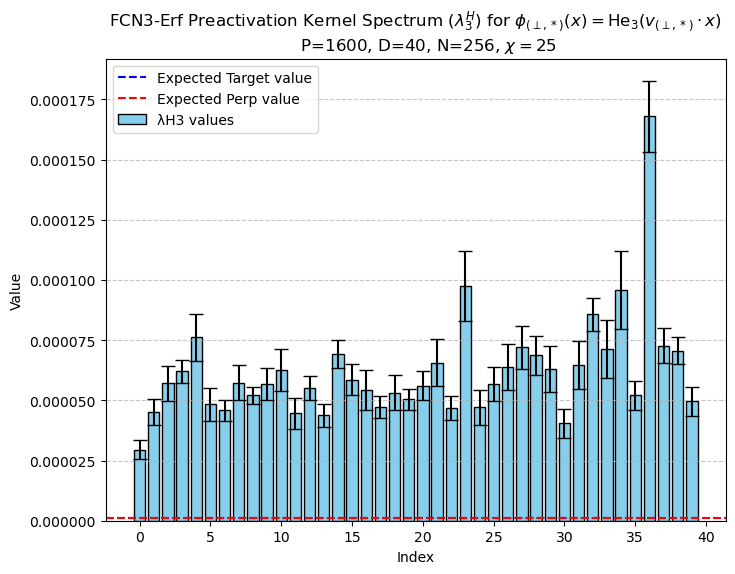

In [115]:
target3 = predictions.lH3T
lH3expected = predictions.lH3P
k = 'λH3'
print(
    f"{k}: {eigdict[k]} ± {eigdict[f'σ{k}']} ")

lH3_min = eigdict[k] - eigdict[f'σ{k}']
lH3_max = eigdict[k] + eigdict[f'σ{k}']
print(
    f"{k}_min: {lH3_min} ")


print(f"{k}_expected: {lH3expected}")
print(
    f"{k}_max: {lH3_max} ")


# Calculate error bars: asymmetric from min to max relative to heights
yerr_min = eigdict[k] - lH3_min  # Lower error
yerr_max = lH3_max - eigdict[k]  # Upper error
yerr = np.array([yerr_min, yerr_max])  # Shape (2, n) for asymmetric errors

# X positions for bars (assuming indexed by array position)
x = np.arange(len(eigdict[k]))

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(x, eigdict[k], yerr=yerr, capsize=5,
        color='skyblue', edgecolor='black', label='λH3 values')

plt.axhline(y=target3, color='blue',
            linestyle='--', label='Expected Target value')

# Add the red dashed line (horizontal across all bars if lH3expected is scalar; or point-wise if array)
if np.isscalar(lH3expected):
    plt.axhline(y=lH3expected, color='red',
                linestyle='--', label='Expected Perp value')
else:
    plt.plot(x, lH3expected, color='red', linestyle='--',
             marker='o', label='Expected Perp values')

# Labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('FCN3-Erf Preactivation Kernel Spectrum ($\lambda^H_3$) for $\phi_{(\perp, *)}(x) = $He$_3(v_{(\perp, *)} \cdot x)$ \n \
    P=1600, D=40, N=256, $\chi=25$ \
')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.ylim(0.0,0.001)
# Show the plot
plt.show()

I see in this plotobs

In [21]:
Y.shape

# Large matrix projection
P = 30

lH1 = model.H_eig(X_inf, Y1_inf)
lH3 = model.H_eig(X_inf, Y3_inf)
lK1 = model.K_eig(X_inf, Y1_inf)
lK3 = model.K_eig(X_inf, Y3_inf)

# Ensure we only index up to available eigenvalues
d_plot = min(int(lH1.shape[0]), int(lK1.shape[0]), 10)

scalarsH1 = {}
scalarsH3 = {}
scalarsK1 = {}
scalarsK3 = {}
muK1 = {}
muK3 = {}

# noise_term = kappa / P
noise_term = float(kappa) / float(P)

for i in range(d_plot):
    scalarsH1[str(i)] = lH1[i].item() if hasattr(
        lH1[i], 'item') else float(lH1[i])
    scalarsH3[str(i)] = lH3[i].item() if hasattr(
        lH3[i], 'item') else float(lH3[i])

    scalarsK1[str(i)] = lK1[i].item() if hasattr(
        lK1[i], 'item') else float(lK1[i])
    scalarsK3[str(i)] = lK3[i].item() if hasattr(
        lK3[i], 'item') else float(lK3[i])

    # learnability mu = lKi / (lKi + kappa/P)
    li_k1 = lK1[i].item() if hasattr(
        lK1[i], 'item') else float(lK1[i])
    li_k3 = lK3[i].item() if hasattr(
        lK3[i], 'item') else float(lK3[i])
    muK1[str(i)] = li_k1 / (li_k1 + noise_term + 1e-30)
    muK3[str(i)] = li_k3 / (li_k3 + noise_term + 1e-30)

# Log to TensorBoard

# Randomized SVD Approach   

In [ ]:
del experimentMF


In [86]:
import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling')
import torch
from Experiment import Experiment 
# experimentMF = Experiment(
#     eps=0.03,
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
#     N=256,
#     d=40,
#     chi=25,
#     P=1600,
#     ens=10,
#     device = torch.device('cuda:1')
# )

# experimentMF = Experiment(
#     eps = 0.03, 
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_40000000_lrA_1.11e-08_time_20251030_121338',
#     N=250,
#     d=25,
#     ens=5,
#     chi=1.0,
#     P=30
# )

# experimentMF = Experiment(
#     eps=0.00,
#     file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935',
#     N=250,
#     d=25,
#     chi=250,
#     P=30,
#     ens=7,
# )

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_300000000_lrA_7.69e-09_time_20251030_175255',
#     P = 130,
#     d=25,
#     N=250,
#     chi=25,
#     ens=25,
#     eps=0.00
# )

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1875_D_25_N_400_epochs_2000000_lrA_1.78e-09_time_20251112_161015',
#     P = 1875,
#     d=25,
#     N=400,
#     chi=100,
#     eps=0.4,
#     ens=5)

# experimentMF = Experiment(
#     d=25,
#     P=30,
#     N=250,
#     ens = 7, 
#     eps = 0.4,
#     chi=250,
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_25000000_lrA_1.11e-07_time_20251113_122128',
# )

# experimentMF = Experiment(
#     file='/home/akiva/exp/fcn3erf/erf_cubic_P_2500_D_50_N_400_epochs_30000000_lrA_1.33e-07_time_20251113_151231/',
#     device=torch.device('cuda:1'),
#     P=2500,
#     d=50,
#     N=400,
#     chi=100,
#     eps=4.0,
#     ens=8)

# experimentMF = Experiment(
#     file = '/home/akiva/exp/fcn3erf/erf_cubic_P_300_D_20_N_200_epochs_30000000_lrA_1.11e-06_time_20251116_110854/',
#     device=torch.device('cuda:1'),
#     P = 300,
#     d=20,
#     N=200,
#     chi=200,
#     eps=4.0,
#     ens = 5)

# experimentMF = Experiment(
#     file='/home/akiva/exp/fcn3erf/erf_cubic_P_250_D_20_N_120_epochs_30000000_lrA_1.33e-07_time_20251116_210435',
#     device=torch.device('cuda:1'),
#     P=250,
#     d=20,
#     N=120,
#     chi=60,
#     eps=0.4,
#     ens=10)

experimentMF = Experiment(
    file='/home/akiva/exp/fcn3erf/erf_cubic_eps_0.3_P_2500_D_40_N_400_epochs_25000000_lrA_1.33e-07_time_20251117_132840/',
    P = 1000,
    d=40,
    N=400,
    chi=100,
    eps=0.3,
    ens=3,
    device=torch.device('cuda:1')
)

import torch
# experimentMFSmallD.load()
experimentMF.load(compute_predictions=True)
model = experimentMF.model
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)

experimentMF.predictions = experimentMF.eig_predictions()
# torch.set_printoptions(precision=8)

# print("Leading order eigenvalues:")
# print(ls[(ls > 1e-2) & (ls < 5e-1)])
# print("Second order eigenvalues")

# print(ls[(ls > 1e-5) & (ls < 1e-3)])


Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.3_P_2500_D_40_N_400_epochs_25000000_lrA_1.33e-07_time_20251117_132840/model.pth


In [87]:
X, Yi = experimentMF.large_dataset(p_large=10000, device=experimentMF.device)
Y1, Y3 = Yi

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
import torch
from Experiment import Experiment 

experiments = [
    Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
        N=256,
        d=40,
        chi=25,
        P=1600,
        ens=10,
        device = torch.device('cuda:1')
    ),Experiment(
        eps = 0.03, 
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_40000000_lrA_1.11e-08_time_20251030_121338',
        N=250,
        d=25,
        ens=5,
        chi=1.0,
        P=30
    ),Experiment(
        eps=0.00,
        file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935',
        N=250,
        d=25,
        chi=250,
        P=30,
        ens=7,
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_130_D_25_N_250_epochs_300000000_lrA_7.69e-09_time_20251030_175255',
        P = 130,
        d=25,
        N=250,
        chi=25,
        ens=25,
        eps=0.00
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1875_D_25_N_400_epochs_2000000_lrA_1.78e-09_time_20251112_161015',
        P = 1875,
        d=25,
        N=400,
        chi=100,
        eps=0.4,
        ens=5
    ), Experiment(
        d=25,
        P=30,
        N=250,
        ens = 7, 
        eps = 0.4,
        chi=250,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_30_D_25_N_250_epochs_25000000_lrA_1.11e-07_time_20251113_122128'
    ), Experiment(
        file='/home/akiva/exp/fcn3erf/erf_cubic_P_2500_D_50_N_400_epochs_30000000_lrA_1.33e-07_time_20251113_151231/',
        device=torch.device('cuda:1'),
        P=2500,
        d=50,
        N=400,
        chi=100,
        eps=4.0,
        ens=8
    ), Experiment(
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_300_D_20_N_200_epochs_30000000_lrA_1.11e-06_time_20251116_110854/',
        device=torch.device('cuda:1'),
        P = 300,
        d=20,
        N=200,
        chi=200,
        eps=4.0,
        ens = 5
    ), Experiment(
        file='/home/akiva/exp/fcn3erf/erf_cubic_P_250_D_20_N_120_epochs_30000000_lrA_1.33e-07_time_20251116_210435',
        device=torch.device('cuda:1'),
        P=250,
        d=20,
        N=120,
        chi=60,
        eps=0.4,
        ens=10
    ), Experiment(
    file='/home/akiva/exp/fcn3erf/erf_cubic_eps_0.3_P_2500_D_40_N_400_epochs_25000000_lrA_1.33e-07_time_20251117_132840/',
    P = 1000,
    d=40,
    N=400,
    chi=100,
    eps=0.3,
    ens=3,
    device=torch.device('cuda:1'))
]

/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/home/akiva/miniconda3/envs/ml_env/lib/python3.11/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/tmp/ipykernel_1953842/3341397180.py:37: RuntimeWarning: divide by zero encountered in log
  log_density_T = -np.log(countsT * bw(bin_edgesT))  # add epsilon to avoid log(0)


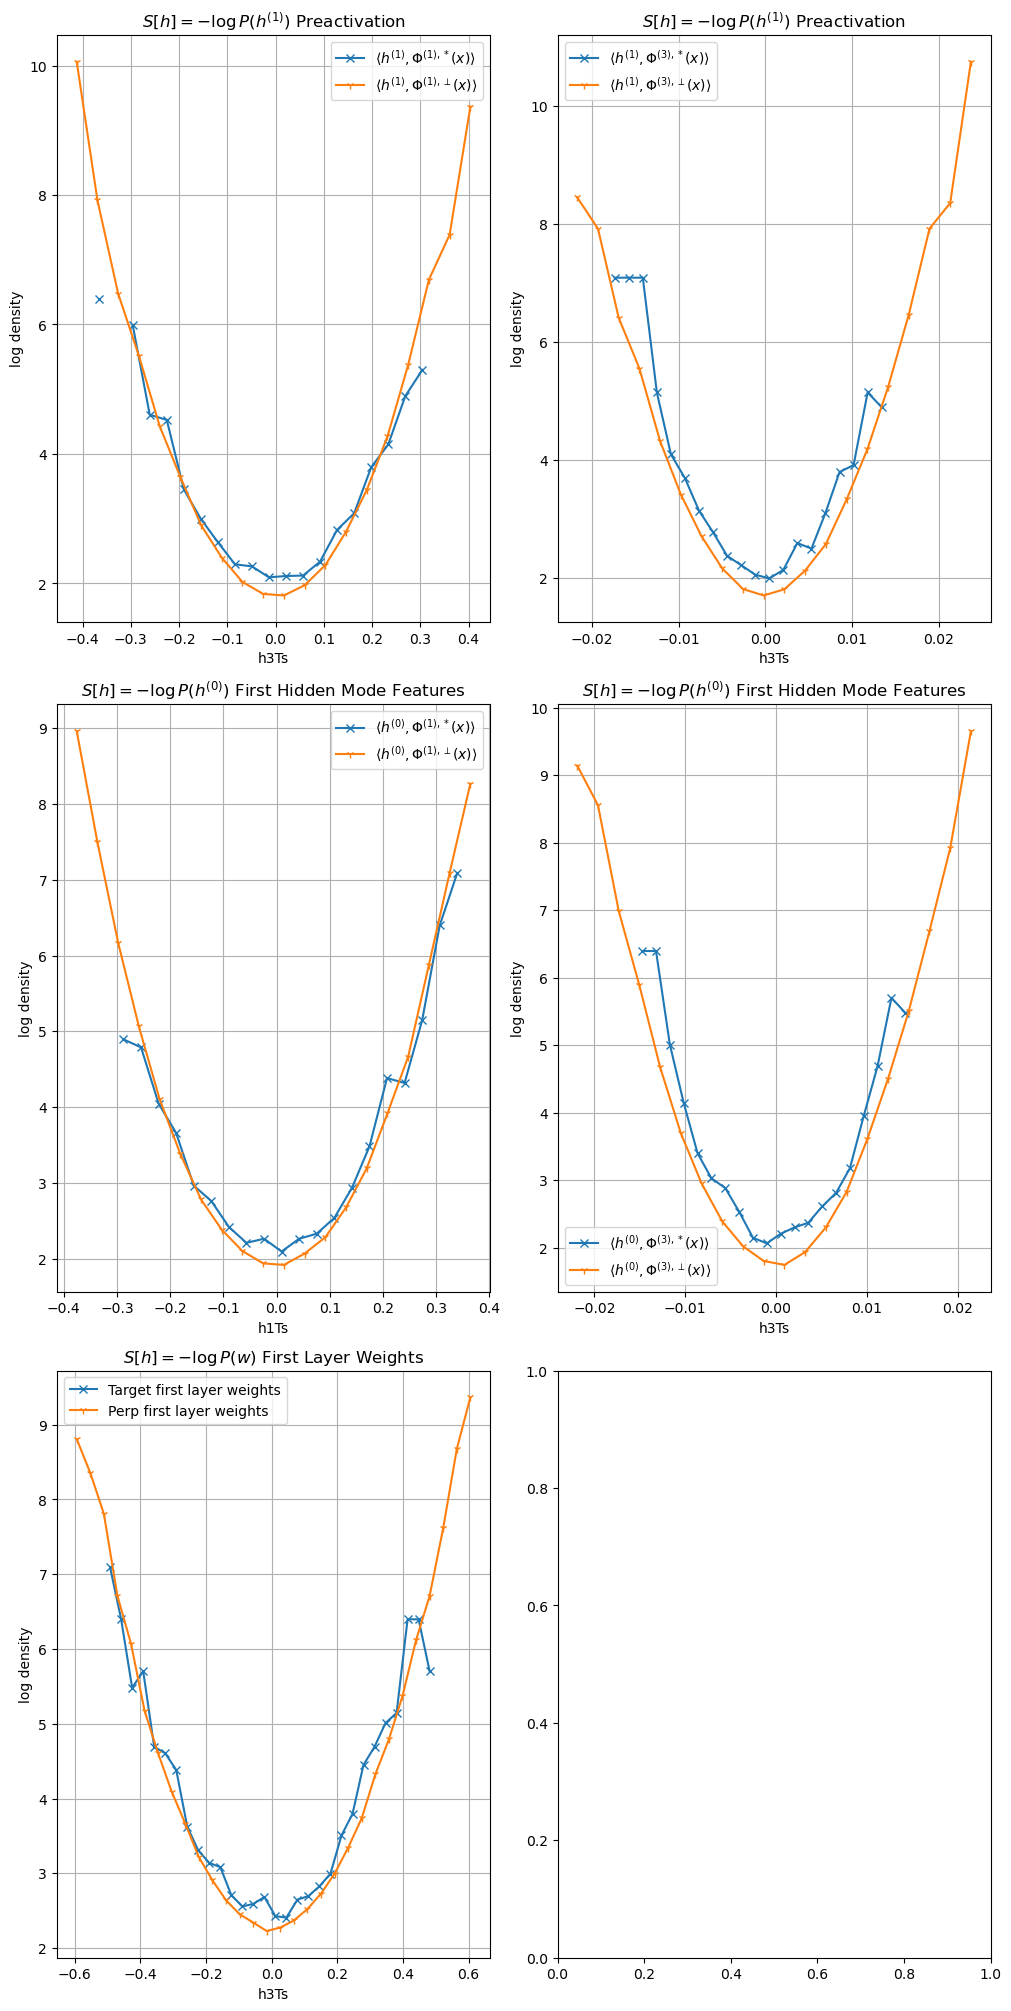

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
import torch
from Experiment import Experiment 

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
X, Yi = experimentMF.large_dataset(p_large=3000)
Y1, Y3 = Yi
model = experimentMF.model
model.to(experimentMF.device)
def log_density_of_projections(h,y):

    hs = torch.einsum('uji,uk->jik', h, y) / (y.shape[0])
    heTs = hs.flatten(start_dim=0, end_dim=1)[:,0].detach().cpu().numpy()
    hePs = hs.flatten(start_dim=0, end_dim=1)[:,1:].detach().cpu().numpy().flatten()

    countsT, bin_edgesT = np.histogram(heTs, bins=20,density= True)
    countsP, bin_edgesP = np.histogram(hePs, bins=20,density= True)

    # Bin width
    bw = lambda be: be[1] - be[0]
    bc = lambda be: 0.5 * (be[:-1] + be[1:])
    # Compute log density
    log_density_T = -np.log(countsT * bw(bin_edgesT))  # add epsilon to avoid log(0)
    log_density_P = -np.log(countsP * bw(bin_edgesP))  # add epsilon to avoid log(0)
    return bc(bin_edgesT), log_density_T, bc(bin_edgesP), log_density_P

h1 = model.h1_preactivation(X)
h0 = torch.erf(torch.einsum(
            'qkl,ul->uqk',
            model.W0, X
        ))
bc1T, ld1T, bc1P, ld1P = log_density_of_projections(h1, Y1)
bc3T, ld3T, bc3P, ld3P = log_density_of_projections(h1, Y3)
h0bc1T, h0ld1T, h0bc1P, h0ld1P = log_density_of_projections(h0, Y1)
h0bc3T, h0ld3T, h0bc3P, h0ld3P = log_density_of_projections(h0, Y3)

# Plot
fig, ax = plt.subplots(3, 2, figsize=(10,20), layout='constrained')
# Option 2: Modifying rcParams

ax[0,0].plot(bc1T, ld1T, marker='x', label='$\\langle h^{(1)} , \Phi^{(1),*}(x) \\rangle$')
ax[0,0].plot(bc1P, ld1P, marker='1', label='$\\langle h^{(1)} , \Phi^{(1),\perp}(x) \\rangle$')
ax[0,0].set_xlabel("h3Ts")
ax[0,0].set_ylabel("log density")
ax[0,0].set_title("$S[h] = -\log P(h^{(1)})$ Preactivation")
ax[0,0].grid(True)
ax[0,0].legend()

ax[0,1].plot(bc3T, ld3T, marker='x', label='$\\langle h^{(1)} , \Phi^{(3),*}(x) \\rangle$')
ax[0,1].plot(bc3P, ld3P, marker='1', label='$\\langle h^{(1)} , \Phi^{(3),\perp}(x) \\rangle$')
ax[0,1].set_xlabel("h3Ts")
ax[0,1].set_ylabel("log density")
ax[0,1].set_title("$S[h] = -\log P(h^{(1)})$ Preactivation")
ax[0,1].grid(True)
ax[0,1].legend()

ax[1,0].plot(h0bc1T, h0ld1T, marker='x', label='$\\langle h^{(0)} , \Phi^{(1),*}(x) \\rangle$')
ax[1,0].plot(h0bc1P, h0ld1P, marker='1', label='$\\langle h^{(0)} , \Phi^{(1),\perp}(x) \\rangle$')
ax[1,0].set_xlabel("h1Ts")
ax[1,0].set_ylabel("log density")
ax[1,0].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
ax[1,0].grid(True)
ax[1,0].legend()
# ax[1,0].set_xlim((-.6,.6))

ax[1,1].plot(h0bc3T, h0ld3T, marker='x', label='$\\langle h^{(0)} , \Phi^{(3),*}(x) \\rangle$')
ax[1,1].plot(h0bc3P, h0ld3P, marker='1', label='$\\langle h^{(0)} , \Phi^{(3),\perp}(x) \\rangle$')
ax[1,1].set_xlabel("h3Ts")
ax[1,1].set_ylabel("log density")
ax[1,1].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
ax[1,1].grid(True)
ax[1,1].legend()
# ax[1,1].set_xlim((-.25,.25))

w0T = model.W0[:,:,0].detach().cpu().numpy()
w0P = model.W0[:,:,1:].detach().cpu().numpy()
ctT, bneT = np.histogram(w0T, bins=30,density= True)
ctP, bneP = np.histogram(w0P, bins=30,density= True)

# Bin width
bw = lambda be: be[1] - be[0]
bc = lambda be: 0.5 * (be[:-1] + be[1:])
# Compute log density
w0ldT = -np.log(ctT * bw(bneT))  # add epsilon to avoid log(0)
w0ldP = -np.log(ctP * bw(bneP))  # add epsilon to avoid log(0)
w0bcT = bc(bneT)
w0bcP = bc(bneP)

ax[2,0].plot(w0bcT, w0ldT, marker='x', label='Target first layer weights')
ax[2,0].plot(w0bcP, w0ldP, marker='1', label='Perp first layer weights')
ax[2,0].set_xlabel("h3Ts")
ax[2,0].set_ylabel("log density")
ax[2,0].set_title("$S[h] = -\log P(w)$ First Layer Weights")
ax[2,0].grid(True)
ax[2,0].legend()
# ax[2,0].set_xlim((-.5,.5))

# ax[2,1].plot(h0bc3T, h0ld3T, marker='x', label='$\\langle h^{(0)} , \Phi^{(3),*}(x) \\rangle$')
# ax[2,1].plot(h0bc3P, h0ld3P, marker='o', label='$\\langle h^{(0)} , \Phi^{(3),\perp}(x) \\rangle$')
# ax[2,1].set_xlabel("h3Ts")
# ax[2,1].set_ylabel("log density")
# ax[2,1].set_title("$S[h] = -\log P(h^{(0)})$ First Hidden Mode Features")
# ax[2,1].grid(True)
# ax[2,1].legend()

plt.show()

/tmp/ipykernel_1091460/1870477502.py:45: RuntimeWarning: divide by zero encountered in log
  ldT = -np.log(ctT * bw(bneT))
/tmp/ipykernel_1091460/1870477502.py:61: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs.legend()


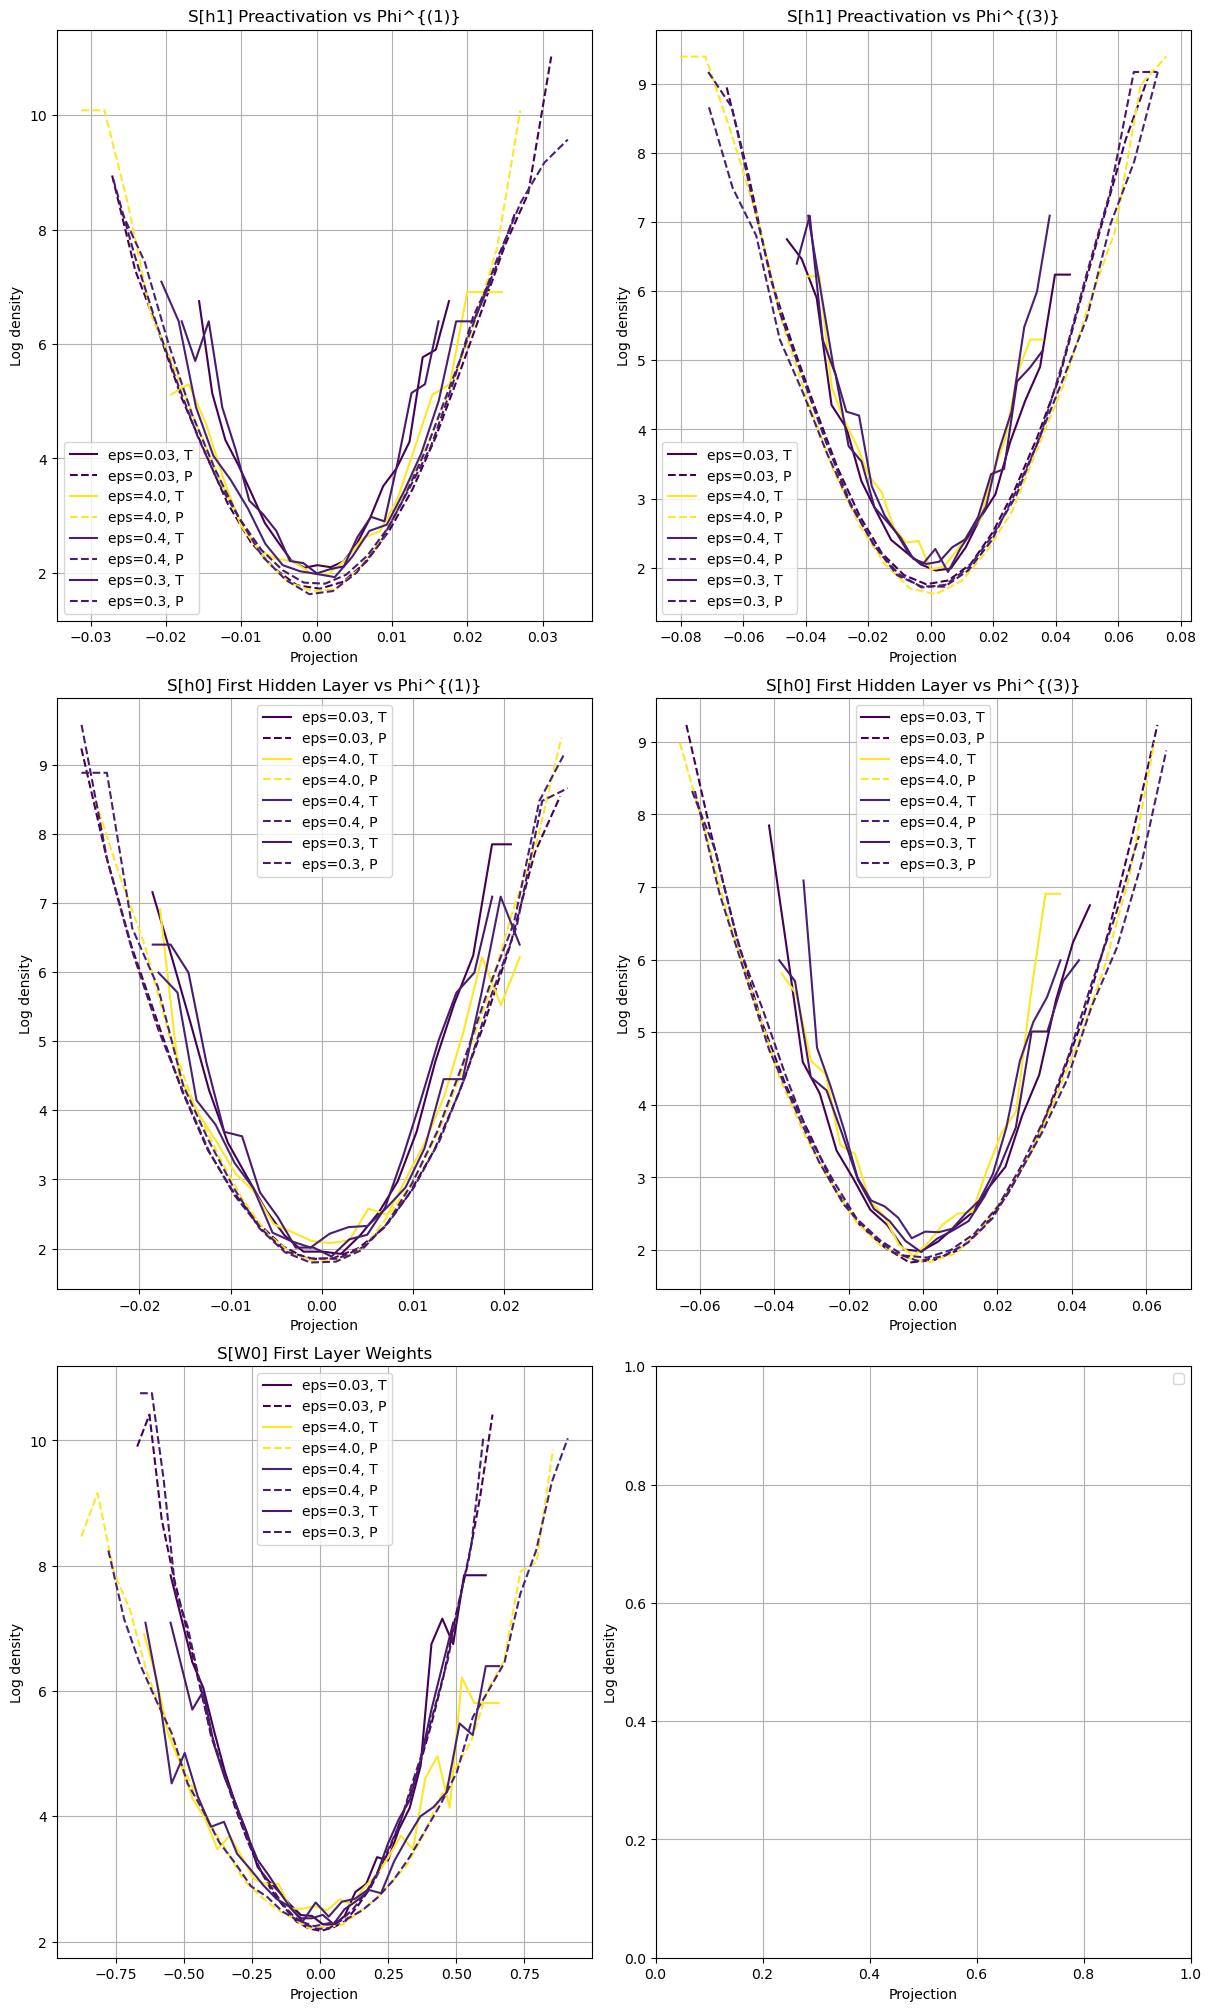

In [82]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Define line styles
line_styles = {'T': '-', 'P': '--'}

# Normalize epsilon values for colormap
eps_values = [exp.eps if hasattr(exp, 'eps') else 0.0 for exp in experiments]
norm = plt.Normalize(min(eps_values), max(eps_values))
cmap = cm.viridis

# Precompute X and model from first experiment (assuming all experiments use same input space)

fig, ax = plt.subplots(3, 2, figsize=(12, 20), layout='constrained')

for experiment in experiments:
    model = experiment.model
    model.to(torch.device('cuda:1'))
    # Compute preactivations
    X, _ = experiment.large_dataset(p_large=10000, device=torch.device('cuda:1'))

    h1 = model.h1_preactivation(X)
    h0 = torch.erf(torch.einsum('qkl,ul->uqk', model.W0, X))
    
    # Compute log densities for Y1 and Y3
    for Y, row_label in zip([Y1, Y3], ['1','2']):
        bcT, ldT, bcP, ldP = log_density_of_projections(h1, Y)
        ax_idx = (0, int(row_label)-1)
        ax[0, int(row_label)-1].plot(bcT, ldT, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
        ax[0, int(row_label)-1].plot(bcP, ldP, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')
        
        # First hidden layer
        bcT0, ldT0, bcP0, ldP0 = log_density_of_projections(h0, Y)
        ax[1, int(row_label)-1].plot(bcT0, ldT0, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
        ax[1, int(row_label)-1].plot(bcP0, ldP0, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')

    # First layer weights
    w0T = model.W0[:,:,0].detach().cpu().numpy()
    w0P = model.W0[:,:,1:].detach().cpu().numpy()
    ctT, bneT = np.histogram(w0T, bins=30,density=True)
    ctP, bneP = np.histogram(w0P, bins=30,density=True)
    bw = lambda be: be[1]-be[0]
    bc = lambda be: 0.5*(be[:-1]+be[1:])
    ldT = -np.log(ctT * bw(bneT))
    ldP = -np.log(ctP * bw(bneP))
    ax[2,0].plot(bc(bneT), ldT, color=cmap(norm(experiment.eps)), linestyle=line_styles['T'], label=f'eps={experiment.eps}, T')
    ax[2,0].plot(bc(bneP), ldP, color=cmap(norm(experiment.eps)), linestyle=line_styles['P'], label=f'eps={experiment.eps}, P')

# Titles and labels
ax[0,0].set_title("S[h1] Preactivation vs Phi^{(1)}")
ax[0,1].set_title("S[h1] Preactivation vs Phi^{(3)}")
ax[1,0].set_title("S[h0] First Hidden Layer vs Phi^{(1)}")
ax[1,1].set_title("S[h0] First Hidden Layer vs Phi^{(3)}")
ax[2,0].set_title("S[W0] First Layer Weights")
for axs in ax.flatten():
    axs.set_xlabel("Projection")
    axs.set_ylabel("Log density")
    axs.grid(True)
    # Optional: Only show legend in first row to avoid clutter
    axs.legend()

plt.show()


[Random Omega generation] 0.0000s
[  res chunk [0:1000]] 0.0024s
[res computation (chunks of 4096)] 0.0040s
[QR factorisation] 0.0023s
[  Z chunk [0:1000]] 0.0000s
[Z computation (chunks of 4096)] 0.0023s
[B = Q.T @ Z] 0.0000s
[eigvalsh] 0.1372s
[final sort] 0.0000s


In [68]:
experimentMF.predictions

Eigenvalues(lJ1T=0.010545270230877759, lJ3T=4.3401441413413423e-05, lH1T=0.04421250783439252, lH3T=4.365973605191249e-05, lJ1P=0.010610329539460598, lJ3P=4.42097064144154e-05, lH1P=0.010610329539460598, lH3P=4.42097064144154e-05)

In [1]:
experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_P_1600_D_40_N_256_epochs_40000000_lrA_6.25e-11_time_20251030_174053',
        N=256,
        d=40,
        chi=25,
        P=1600,
        ens=10,
        device = torch.device('cuda:1')
    )


experimentGP = Experiment(
    file='',
    P=experimentMF.P,
    d=experimentMF.d,
    N=experimentMF.N,
    chi=experimentMF.chi,
    eps=experimentMF.eps,
    ens=experimentMF.ens,
    device=torch.device('cuda:1')
)

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )

X, Yi = experimentMF.large_dataset(p_large=3000, device=experimentMF.device)

experimentGP.model.device = experimentGP.device
experimentGP.model.to(experimentGP.device)
ls_GP = experimentGP.model.H_eig_random_svd(X, k=500)


model = experimentMF.model
experimentMF.predictions = experimentMF.eig_predictions()
experimentMF.model.device = experimentMF.device
experimentMF.model.to(experimentMF.device)


NameError: name 'Experiment' is not defined

In [ ]:


experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cuda:1')
    )
    
experimentGP.predictions = experimentMF.eig_predictions()

import matplotlib.pyplot as plt
ls_np = ls[40:].detach().cpu().numpy()
ls_GP_np = ls_GP[40:].detach().cpu().numpy()
plt.axhline(y=experimentGP.predictions.lH3T, color='blue',
            linestyle='--', label='MF Target lH3 Expected')
plt.axhline(y=experimentGP.predictions.lH3P, color='orange', linestyle='--', label='MF Perp lH3 Expected')
plt.plot(ls_np, marker='o', label='MF Model')
plt.plot(ls_GP_np, marker='x', label='GP Initialization Model')
# plt.yscale('log')
plt.legend()
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue (log scale)')
plt.title('Eigenvalues of H via Randomized SVD')
# plt.xscale('log')
plt.grid(True, which="both", ls="--")
plt.show()

NameError: name 'Experiment' is not defined

In [11]:
import numpy as np


def same_order_mask(a, b, eps=1):
    """
    Returns True where |floor(log10|a|) - floor(log10|b|)| <= eps
    eps=0  → exact same order (your original)
    eps=1  → allows one order of magnitude difference (most common soft version)
    """
    a, b = np.asarray(a), np.asarray(b)
    zero = (a == 0) & (b == 0)
    both_nonzero = (a != 0) & (b != 0)
    exp_a = np.log10(np.abs(a))
    exp_b = np.log10(np.abs(b))
    close = np.abs(exp_a - exp_b) <= eps
    return zero | (both_nonzero & close)

In [14]:
Sigma.diagonal()[0] / X.shape[0]

tensor(0.0658)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
from Experiment import Experiment 
%load_ext autoreload
%autoreload 2

experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cpu')
    )
# experimentMF = Experiment(
#         eps=0.00,
#         file = '/home/akiva/exp/fcn3erf/erf_P_30_D_25_N_250_epochs_250000000_lrA_1.11e-07_time_20250922_144935',
#         N=250,
#         d=25,
#         chi=250,
#         P=30,
#         ens=7,
#     )
experimentMF.load()
experimentMF.model.to(experimentMF.device)
experimentMF.predictions = experimentMF.eig_predictions()
X, Y1,Y3 = experimentMF.large_dataset(p_large = 3000, flat=True)
experimentMF.model.device = experimentMF.device
print("Model device is: ", experimentMF.model.device)
# Available CPU memory:
import psutil
mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**3):.2f} GB")
# Available memory not in use:
print(f"Free memory: {mem.free / (1024**3):.2f} GB")
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 2000, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
ls = Sigma.diagonal() / X.shape[0]
Y = Y1 / torch.norm(Y1, dim=0) 
left_eigenvalues = (torch.matmul(Y.t(), U) @ _S.diag() @ torch.matmul(U.T, Y)).diagonal() / torch.norm(Y, dim=0)/ X.shape[0]
ls = experimentMF.model.H_eig_random_svd(X, k=2000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401/model.pth
Model device is:  cpu
Available memory: 54.82 GB
Free memory: 7.39 GB
Computing H_random_QB on device:  cpu
Computing H_random_QB on device:  cpu
[Random Omega generation] 0.1030s
[  res chunk [0:3000]] 0.1502s
[res computation (chunks of 4096)] 0.1524s
[QR factorisation] 0.2112s
[  Z chunk [0:3000]] 0.2583s
[Z computation (chunks of 4096)] 0.2606s
[Random Omega generation] 0.1240s
[  res chunk [0:3000]] 0.1547s
[res computation (chunks of 4096)] 0.1560s
[QR factorisation] 0.2103s
[  Z chunk [0:3000]] 0.2815s
[Z computation (chunks of 4096)] 0.2837s
[B = Q.T @ Z] 0.0964s
[eigvalsh] 0.2786s
[final sort] 0.0023s


In [15]:
ls3.shape

torch.Size([2025])

In [16]:
X, Y1,Y3 = experimentMF.large_dataset(p_large = 3000, flat=True)

Q, Z = experimentMF.model.H_random_QB(X, k = 2000, p=10)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
ls = Sigma.diagonal() / X.shape[0]
Y = Y1 / torch.norm(Y1, dim=0) 
left_eigenvalues = (torch.matmul(Y.t(), U) @ _S.diag() @ torch.matmul(U.T, Y)).diagonal() / torch.norm(Y, dim=0)/ X.shape[0]
ls = experimentMF.model.H_eig_random_svd(X, k=2000)

Computing H_random_QB on device:  cpu
Computing H_random_QB on device:  cpu
[Random Omega generation] 0.1142s
[  res chunk [0:3000]] 0.1513s
[res computation (chunks of 4096)] 0.1536s
[QR factorisation] 0.2057s
[  Z chunk [0:3000]] 0.2711s
[Z computation (chunks of 4096)] 0.2734s
[Random Omega generation] 0.1266s
[  res chunk [0:3000]] 0.1572s
[res computation (chunks of 4096)] 0.1595s
[QR factorisation] 0.2264s
[  Z chunk [0:3000]] 0.2751s
[Z computation (chunks of 4096)] 0.2774s
[B = Q.T @ Z] 0.0976s
[eigvalsh] 0.2694s
[final sort] 0.0000s


In [19]:
ls[experimentMF.d:]

tensor([ 1.7580e-04,  1.6809e-04,  1.6725e-04,  ..., -2.9161e-18,
        -2.9715e-18, -3.0163e-18])

<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\c'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:52: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:60: SyntaxWarning: invalid escape sequence '\l'
<>:63: SyntaxWarning: invalid escape sequence '\l'
<>:69: SyntaxWarning: invalid escape sequence '\l'
<>:75: SyntaxWarning: invalid escape sequence '\l'
<>:80: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_64650/1736957155.py:48: SyntaxWarning: invalid escape sequence '\m'

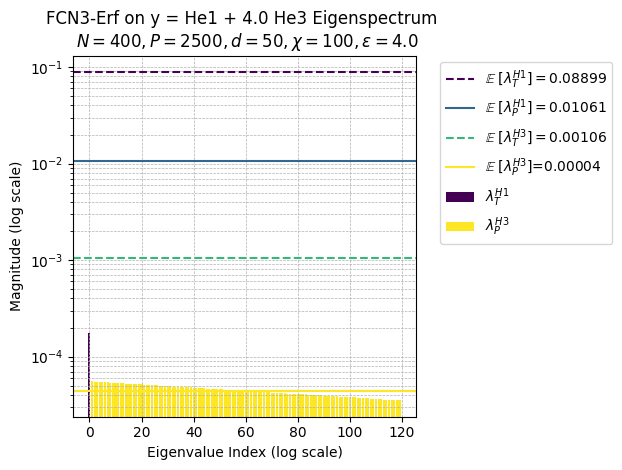

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch
MF_eigenvalues = experimentMF.predictions
# ------------------------------------------------------------------
# 1. Choose colormap
# ------------------------------------------------------------------
cmap_name = "viridis"          # or "magma"
cmap = plt.get_cmap(cmap_name)
colors = cmap(np.linspace(0, 1, 4))

# ------------------------------------------------------------------
# 2. Move ls3 to CPU and convert to NumPy early
# ------------------------------------------------------------------
ls3 = ls[experimentMF.d:] # assuming ls is your eigenvalue tensor
ls3_np = ls3.detach().cpu().numpy()
eig_upto = ls3.shape[0]  # or set to desired number of eigenvalues



# ------------------------------------------------------------------
# 3. Create boolean masks → **convert to NumPy immediately**
# ------------------------------------------------------------------
idx_big_np = (ls3_np == ls3_np.max()
              ) & (np.arange(len(ls3_np)) < eig_upto)
idx_mid1_np = same_order_mask(experimentMF.predictions.lH1P, ls3_np) & (ls3_np < ls3_np.max())  & (np.arange(len(ls3_np)) < eig_upto)
idx_mid_np = ~idx_mid1_np & same_order_mask(experimentMF.predictions.lH3T, ls3_np, eps=0.1) & (np.arange(len(ls3_np)) < eig_upto)
idx_small_np = same_order_mask(experimentMF.predictions.lH3P, ls3_np, eps=0.1) & (
    np.arange(len(ls3_np)) < eig_upto)

# Count sizes
n_big   = np.sum(idx_big_np)
n_mid1 = np.sum(idx_mid1_np)
n_mid   = np.sum(idx_mid_np)
n_small = np.sum(idx_small_np)

# ------------------------------------------------------------------
# 4. Build bar positions (NumPy)
# ------------------------------------------------------------------
pos_big   = np.arange(0, n_big)
pos_mid1 = np.arange(n_big, n_big + n_mid1)
pos_mid   = np.arange(n_big + n_mid1, n_big + n_mid + n_mid1)
pos_small = np.arange(n_big + n_mid + n_mid1, n_big + n_mid + n_mid1 + n_small)

# ------------------------------------------------------------------
# 5. Horizontal target lines
# ------------------------------------------------------------------
plt.axhline(y=MF_eigenvalues.lH1T, color=colors[0], linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]=$' + f'{MF_eigenvalues.lH1T:.5f}')
plt.axhline(y=MF_eigenvalues.lH1P, color=colors[1], linestyle='-',
            label='$\mathbb{E}\;[\lambda^{H1}_P]=$' + f'{MF_eigenvalues.lH1P:.5f}')
plt.axhline(y=MF_eigenvalues.lH3T, color=colors[2], linestyle='--',
            label='$\mathbb{E}\;[\lambda^{H3}_T]=$' + f'{MF_eigenvalues.lH3T:.5f}')
plt.axhline(y=MF_eigenvalues.lH3P, color=colors[3], linestyle='-',  label='$\mathbb{E}\;[\lambda^{H3}_P]$='
            + f'{MF_eigenvalues.lH3P:.5f}')

# ------------------------------------------------------------------
# 6. Bar plots – **all NumPy**
# ------------------------------------------------------------------
if n_big > 0:
    plt.bar(pos_big, ls3_np[idx_big_np], color=colors[0], label='$\lambda^{H1}_T$')

if n_mid > 0:
    plt.bar(pos_mid, ls3_np[idx_mid_np], color=colors[2], label='$\lambda^{H1}_P$')

if n_mid1 > 0:
    mid1_vals = ls3_np[idx_mid1_np]
    mid1_pos  = pos_mid1

    plt.bar(pos_mid1, mid1_vals, color=colors[1], label='$\lambda^{H3}_T$')

if n_small > 0:
    small_vals = ls3_np[idx_small_np]
    small_pos  = pos_small

    plt.bar(small_pos, small_vals, color=colors[3], label='$\lambda^{H3}_P$')

# ------------------------------------------------------------------
# 7. Finalize
# ------------------------------------------------------------------
plt.title(f"FCN3-Erf on y = He1 + 4.0 He3 Eigenspectrum \n $N=400, P=2500, d=50, \chi=100, \epsilon=4.0$")
plt.yscale('log')
# plt.xscale('log')
plt.xlabel("Eigenvalue Index (log scale)")
plt.ylabel("Magnitude (log scale)")
plt.legend(bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()

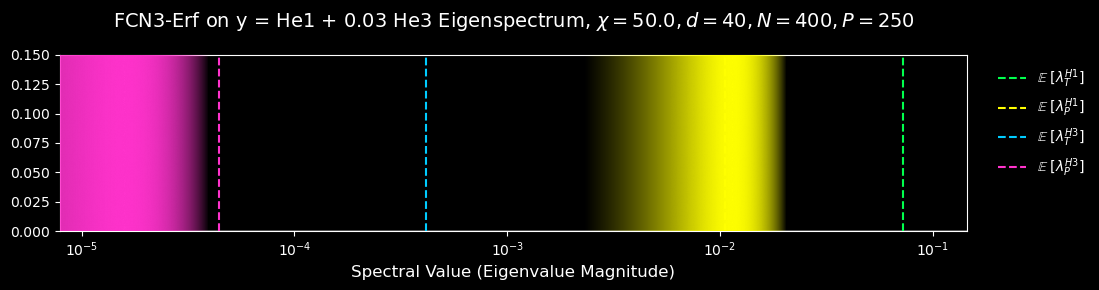

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------------------------------------------
# 1. Glowy neon colors (RGBA)
# ------------------------------------------------------------------
glow_colors = [
    (0.0, 1.0, 0.3, 1.0),   # Neon green
    (1.0, 1.0, 0.0, 1.0),   # Neon yellow
    (0.0, 0.8, 1.0, 1.0),   # Neon cyan
    (1.0, 0.2, 0.8, 1.0)    # Neon magenta
]

# ------------------------------------------------------------------
# 2. Move ls3 to CPU and convert to NumPy
# ------------------------------------------------------------------
ls3 = ls
ls3_np = ls3.detach().cpu().numpy()

# ------------------------------------------------------------------
# 3. Masks
# ------------------------------------------------------------------
idx_big_np = (ls3_np > 0.1)
idx_mid_np = (ls3_np <= 0.1) & (ls3_np > 1e-3)
idx_small_np = (ls3_np <= 1e-4)

vals_big = ls3_np[idx_big_np]
vals_mid = ls3_np[idx_mid_np]
vals_small = ls3_np[idx_small_np]
vals_h3t = vals_small[:1] if len(vals_small) > 0 else np.array([])
vals_h3p = vals_small[1:] if len(vals_small) > 1 else np.array([])

groups = [
    (vals_big, glow_colors[0], '$\lambda^{H1}_T$'),
    (vals_mid, glow_colors[1], '$\lambda^{H1}_P$'),
    (vals_h3t, glow_colors[2], '$\lambda^{H3}_T$'),
    (vals_h3p, glow_colors[3], '$\lambda^{H3}_P$')
]

# ------------------------------------------------------------------
# 4. Compute mean and std for each group
# ------------------------------------------------------------------
means, stds, labels, colors = [], [], [], []
for vals, color, label in groups:
    if len(vals) > 0:
        mean_val = np.mean(vals)
        std_val = np.std(vals) if len(vals) > 1 else 0.0
        if std_val == 0:
            std_val = 1e-10  # avoid zero-width
        means.append(mean_val)
        stds.append(std_val)
        labels.append(label)
        colors.append(color)

# ------------------------------------------------------------------
# 5. Create figure with black background
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 3))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')

# Horizontal baseline
ax.axhline(y=0, color='gray', linewidth=1.2, alpha=0.7)

height = 0.15  # Short lines for spectral feel

# ------------------------------------------------------------------
# 6. Plot spectral spread: flat height, alpha fade over ±1σ
# ------------------------------------------------------------------
for mean, std, color, label in zip(means, stds, colors, labels):
    if std == 0:
        ax.vlines(mean, 0, height, colors=color, linewidth=3, label=label, zorder=5)
        continue

    # Create 1D gradient: full alpha at center, fade to 0 at edges
    n = 256
    gradient = np.linspace(0, 1, n)
    alpha = np.abs(gradient - 0.5) * 2  # 1 at center, 0 at edges
    alpha = 1 - alpha**2  # smoother fade
    alpha = np.clip(alpha, 0, 1)

    # Build RGBA image: [1, n, 4]
    rgba = np.zeros((1, n, 4))
    rgba[0, :, 0] = color[0]  # R
    rgba[0, :, 1] = color[1]  # G
    rgba[0, :, 2] = color[2]  # B
    rgba[0, :, 3] = alpha     # A

    # Extent: [left, right, bottom, top]
    left = mean - std
    right = mean + std
    extent = [left, right, 0, height]

    ax.imshow(rgba, extent=extent, aspect='auto', origin='lower', interpolation='bicubic', zorder=3)

# ------------------------------------------------------------------
# 7. Overlay expected values as sharp solid lines
# ------------------------------------------------------------------
expected_lines = [
    (MF_eigenvalues.lH1T, glow_colors[0], '$\mathbb{E}\;[\lambda^{H1}_T]$'),
    (MF_eigenvalues.lH1P, glow_colors[1], '$\mathbb{E}\;[\lambda^{H1}_P]$'),
    (MF_eigenvalues.lH3T, glow_colors[2], '$\mathbb{E}\;[\lambda^{H3}_T]$'),
    (MF_eigenvalues.lH3P, glow_colors[3], '$\mathbb{E}\;[\lambda^{H3}_P]$'),
]

for val, color, label in expected_lines:
    ax.vlines(val, 0, height, colors=color, linestyles='--', linewidth=1.5, label=label, zorder=10)

# ------------------------------------------------------------------
# 8. Finalize – clean spectral look
# ------------------------------------------------------------------
plt.xscale('log')
ax.set_xlabel("Spectral Value (Eigenvalue Magnitude)", color='white', fontsize=12)
ax.set_title(f"FCN3-Erf on y = He1 + 0.03 He3 Eigenspectrum, $\\chi={experimentMF.chi: 0.1f},d={experimentMF.d}, N={experimentMF.N}, P={experimentMF.P}$", color='white', fontsize=14, pad=20)

# Ticks and spines
ax.tick_params(axis='both', colors='white', labelsize=10)
for spine in ax.spines.values():
    spine.set_color('white')

# X limits
all_vals = means + [v for v, _, _ in expected_lines]
if all_vals:
    xmin = max(1e-10, min(all_vals) * 0.5)
    xmax = max(all_vals) * 2.0
    plt.xlim(xmin, xmax)

plt.ylim(0, height)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', labelcolor='white', frameon=False, fontsize=10)
plt.tight_layout()
plt.show()

In [55]:
sorted_left_eigenvalues[0] * 3

0.3631747751032451

In [39]:
eig, std = experimentMF.model.H_eig(X, Y1, std=True)
eig = eig.detach().cpu().numpy() 
eig

array([0.12105826, 0.01820733, 0.01475836, 0.01804221, 0.01675018,
       0.01504172, 0.01397929, 0.01635282, 0.01672705, 0.01598615,
       0.01531204, 0.01682266, 0.01540553, 0.0209356 , 0.01918895,
       0.01539665, 0.01681825, 0.01919697, 0.0167039 , 0.01578162,
       0.01584324, 0.01455769, 0.01640668, 0.01609435, 0.01726437])

In [100]:
lH_eigenvalue_normalization = (experimentMF.predictions.lH1P*(experimentMF.d -1) + experimentMF.predictions.lH1T)
experimentMF.predictions.lH1T / lH_eigenvalue_normalization

0.48355152401663504

In [99]:
experimentMF.predictions.lH1P / lH_eigenvalue_normalization

0.021518686499306872

In [104]:
experimentMF.model.H_eig(X, Y1) [:25]

tensor([0.1211, 0.0182, 0.0148, 0.0180, 0.0168, 0.0150, 0.0140, 0.0164, 0.0167,
        0.0160, 0.0153, 0.0168, 0.0154, 0.0209, 0.0192, 0.0154, 0.0168, 0.0192,
        0.0167, 0.0158, 0.0158, 0.0146, 0.0164, 0.0161, 0.0173],
       device='cuda:1')

In [2]:
import juliacall

/home/akiva/miniconda3/envs/ml_env/lib/python3.14/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(
ERROR: ArgumentError: Package PythonCall [6099a3de-0909-46bc-b1f4-468b9a2dfc0d] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] __require_prelocked(pkg::Base.PkgId, env::String)
   @ Base ./loading.jl:2612
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:2490
 [3] macro expansion
   @ ./loading.jl:2418 [inlined]
 [4] macro expansion
   @ ./lock.jl:376 [inlined]
 [5] __require(into::Module, mod::Symbol)
   @ Base ./loading.jl:2383
 [6] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:2359
 [7] top-level scope
   @ none:8

Exception: PythonCall.jl did not start properly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import sys
import scipy.stats as stats
sys.path.insert(0, '/home/akiva/FCNX-Ensembling/lib')
from Experiment import Experiment 


/home/akiva/miniconda3/envs/ml_env/lib/python3.12/site-packages/juliacall/__init__.py:61: UserWarning: torch was imported before juliacall. This may cause a segfault. To avoid this, import juliacall before importing torch. For updates, see https://github.com/pytorch/pytorch/issues/78829.
  warnings.warn(


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
<>:47: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:49: SyntaxWarning: invalid escape sequence '\m'
<>:50: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22579/2321199451.py:47: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
/tmp/ipykernel_22579/2321199451.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
/tmp/ipykernel_22579/2321199451.py:49: SyntaxWarning: invalid escape sequence '\m'
  plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
/tmp/ipykernel_22579

Loaded model state_dict from /home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401/model.pth
Model device is:  cpu
Available memory: 44.25 GB
Free memory: 7.25 GB
Computing H_random_QB on device:  cpu
Computing H_random_QB on device:  cpu
[Random Omega generation] 0.1536s
[  res chunk [0:3000]] 0.1827s
[res computation (chunks of 4096)] 0.1831s
[QR factorisation] 0.2641s
[  Z chunk [0:3000]] 0.3164s
[Z computation (chunks of 4096)] 0.3166s
[Random Omega generation] 0.0567s
[  res chunk [0:3000]] 0.0497s
[res computation (chunks of 4096)] 0.0500s
[QR factorisation] 0.0310s
[  Z chunk [0:3000]] 0.1913s
[Z computation (chunks of 4096)] 0.1917s
[B = Q.T @ Z] 0.0075s
[eigvalsh] 0.0105s
[final sort] 0.0001s


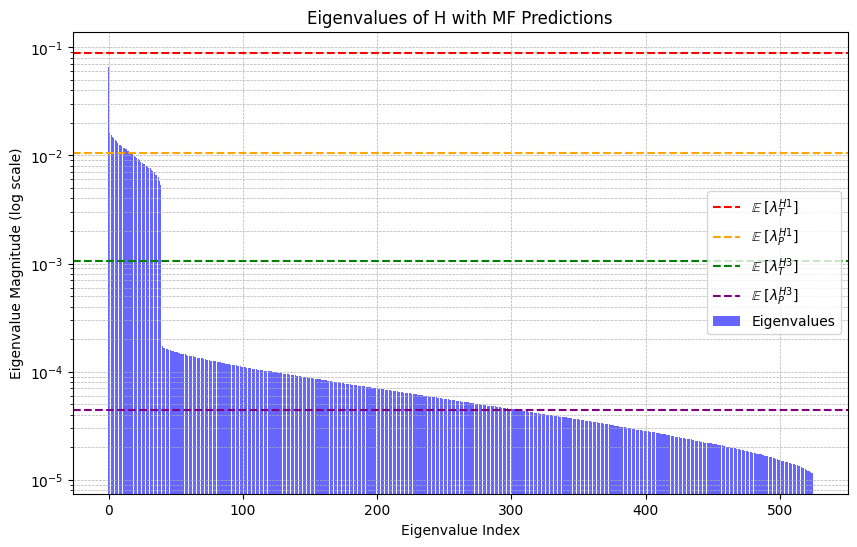

In [10]:


experimentMF = Experiment(
        eps=0.03,
        file = '/home/akiva/exp/fcn3erf/erf_cubic_eps_0.03_P_250_D_40_N_400_epochs_25000000_lrA_1.33e-06_time_20251118_155401',
        N=400,
        d=40,
        chi=50,
        P=250,
        ens=3,
        device = torch.device('cpu')
    )

experimentMF.load()
experimentMF.model.to(experimentMF.device)
experimentMF.predictions = experimentMF.eig_predictions()
X, Y1,Y3 = experimentMF.large_dataset(p_large = 3000, flat=True)
experimentMF.model.device = experimentMF.device
print("Model device is: ", experimentMF.model.device)
# Available CPU memory:
import psutil
mem = psutil.virtual_memory()
print(f"Available memory: {mem.available / (1024**3):.2f} GB")
# Available memory not in use:
print(f"Free memory: {mem.free / (1024**3):.2f} GB")
# compute the svd of the low rank approximaton to H
# Random svd goes from H ∈ ℝ^m*m to its low rank approximation QB ∈ ℝ^m*m with Q ∈ ℝ^m*l and B ∈ ℝ^l*k. 
Q, Z = experimentMF.model.H_random_QB(X, k = 2000, p=500)
Ut, _S, V = torch.linalg.svd(Z.T)
m, n = Z.shape[1], Z.shape[0]
k = min(m, n)
Sigma = torch.zeros(m, n, device=Z.device, dtype=Z.dtype)
Sigma[:k, :k] = torch.diag(_S) 
U = torch.matmul(Q, Ut)
ls = Sigma.diagonal() / X.shape[0]
Y = Y1 / torch.norm(Y1, dim=0) 
Y3 = Y3 / torch.norm(Y3, dim=0)
left_eigenvaluesY1 = (torch.matmul(Y.t(), U) @ _S.diag() @ torch.matmul(U.T, Y)).diagonal() / torch.norm(Y, dim=0)/ X.shape[0]
left_eigenvaluesY3 = (torch.matmul(Y3.t(), U) @ _S.diag() @ torch.matmul(U.T, Y3)).diagonal() / torch.norm(Y3, dim=0)/ X.shape[0]
left_eigenvalues = torch.cat([left_eigenvaluesY1, left_eigenvaluesY3], dim=0)
# Bar plot of all eigenvalues and horizontal lines for all the predictions
plt.figure(figsize=(10, 6))
left_eigenvalues_np = left_eigenvalues.detach().cpu().numpy()
left_eigenvalues_np = experimentMF.model.H_eig_random_svd(X, k=500).detach().cpu().numpy()

sorted_left_eigenvalues = np.sort(left_eigenvalues_np)[::-1]
MF_eigenvalues= experimentMF.predictions
plt.bar(np.arange(len(sorted_left_eigenvalues)), sorted_left_eigenvalues, color='blue', alpha=0.6, label='Eigenvalues')  
plt.axhline(y=MF_eigenvalues.lH1T, color='red', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_T]$')
plt.axhline(y=MF_eigenvalues.lH1P, color='orange', linestyle='--', label='$\mathbb{E}\;[\lambda^{H1}_P]$')
plt.axhline(y=MF_eigenvalues.lH3T, color='green', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_T]$')
plt.axhline(y=MF_eigenvalues.lH3P, color='purple', linestyle='--', label='$\mathbb{E}\;[\lambda^{H3}_P]$')
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue Magnitude (log scale)')
plt.title('Eigenvalues of H with MF Predictions')
plt.legend()
plt.grid(True, which='both', ls='--', lw=0.5)
plt.show()